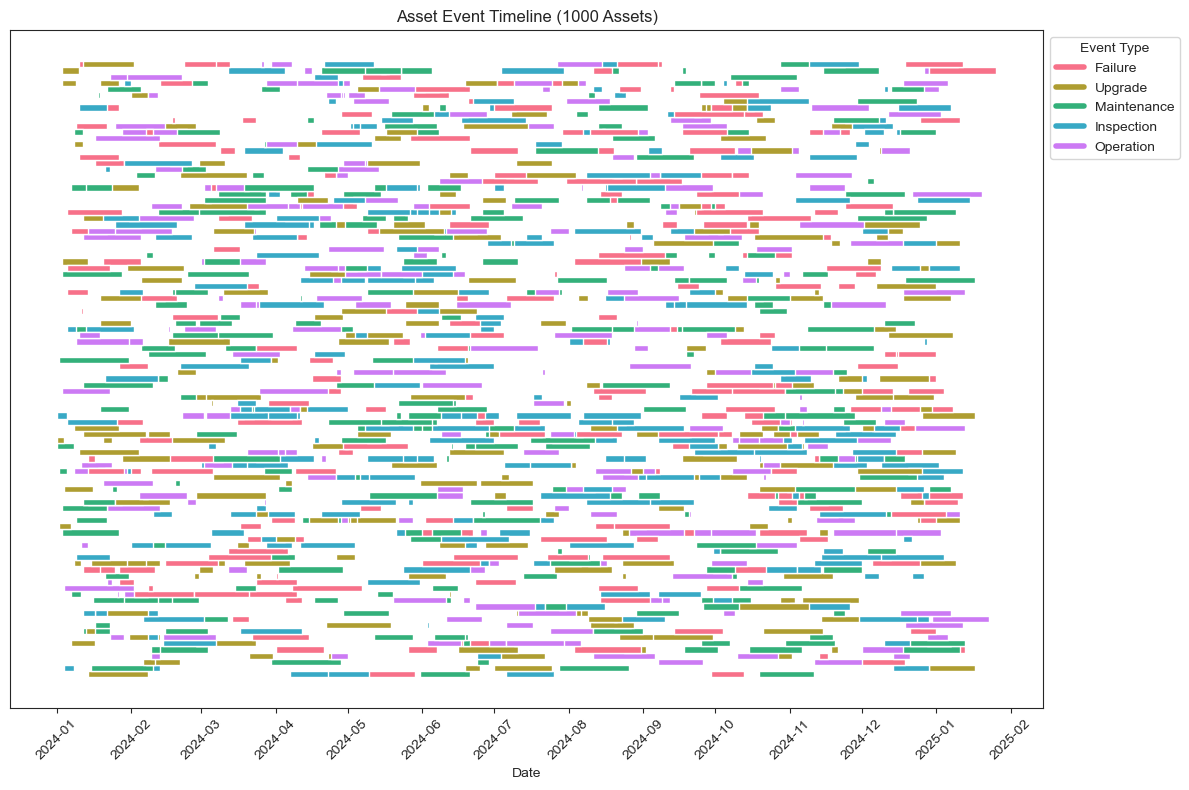

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('ticks')

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_assets = 100
num_events_per_asset = np.random.randint(5, 20, size=num_assets)  # Each asset has 5-20 events

asset_ids = np.concatenate([[f"Asset_{i}"] * num_events_per_asset[i] for i in range(num_assets)])
event_types = np.random.choice(["Maintenance", "Failure", "Operation", "Upgrade", "Inspection"], size=len(asset_ids))
start_dates = pd.to_datetime("2024-01-01") + pd.to_timedelta(np.random.randint(0, 365, size=len(asset_ids)), unit="D")
durations = np.random.randint(1, 30, size=len(asset_ids))
end_dates = start_dates + pd.to_timedelta(durations, unit="D")

df = pd.DataFrame({"asset_id": asset_ids, "start_date": start_dates, "end_date": end_dates, "event_type": event_types})

# Assign unique y-positions for each asset (tightly packed)
asset_order = {asset: idx for idx, asset in enumerate(sorted(df["asset_id"].unique()))}
df["y_pos"] = df["asset_id"].map(asset_order)

# Define event colors using a nice seaborn palette
event_types_unique = df["event_type"].unique()
palette = sns.color_palette("husl", len(event_types_unique))  # Aesthetic distinct colors
event_colors = {event: color for event, color in zip(event_types_unique, palette)}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

for _, row in df.iterrows():
    ax.broken_barh([(mdates.date2num(row["start_date"]), (row["end_date"] - row["start_date"]).days)], 
                   (row["y_pos"], 1), facecolors=event_colors[row["event_type"]])  # Thinner row height

# Format axes
ax.set_yticks([])  # Remove y-ticks since there are too many assets
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_title("Asset Event Timeline (1000 Assets)")

# Legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in event_colors.values()]
ax.legend(handles, event_colors.keys(), title="Event Type", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


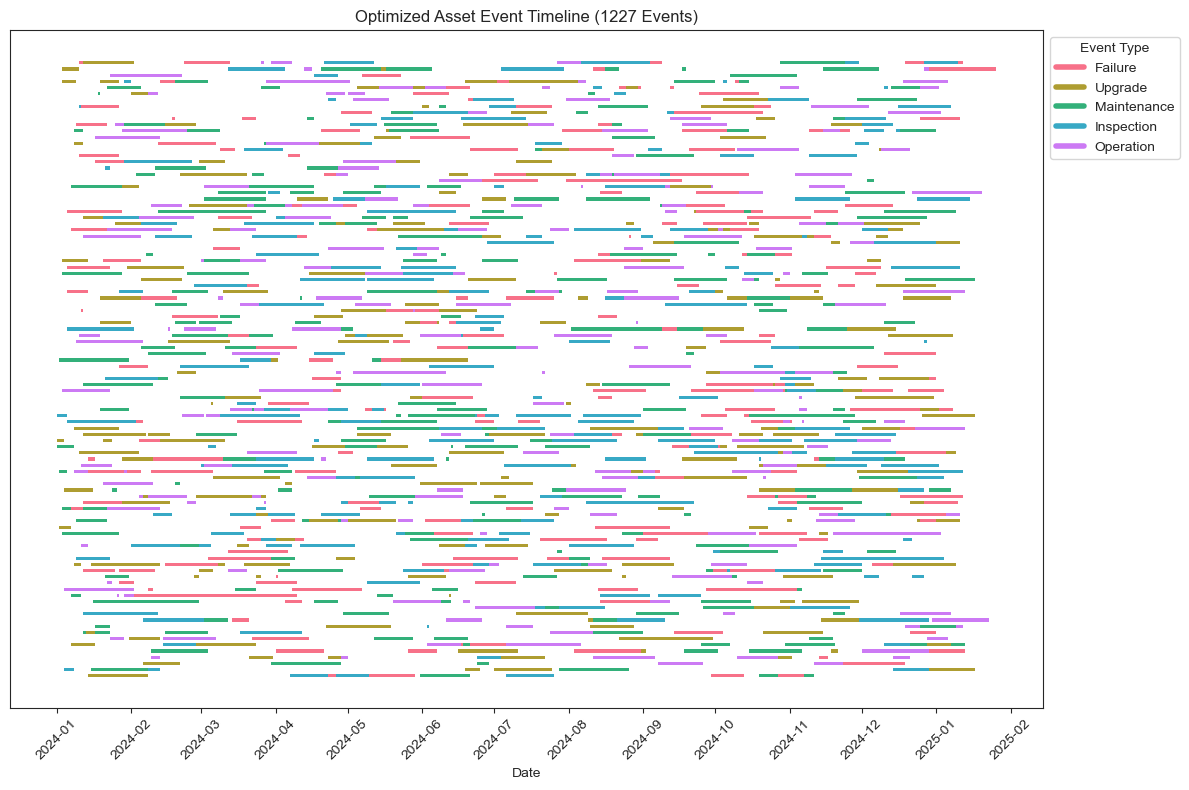

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.collections as mc


# Define event colors using a nice seaborn palette
event_types_unique = df["event_type"].unique()
palette = sns.color_palette("husl", len(event_types_unique))  # Aesthetic distinct colors
event_colors = {event: color for event, color in zip(event_types_unique, palette)}

# Reduce dataset size for efficiency
sample_size = min(20000, len(df))  # Ensure we don't sample more than available
df_sample = df.sample(n=sample_size, random_state=42)

# Convert dates to numeric values for plotting
df_sample["start_num"] = mdates.date2num(df_sample["start_date"])
df_sample["duration"] = (df_sample["end_date"] - df_sample["start_date"]).dt.days

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for efficient plotting
bars = [(row["start_num"], row["duration"]) for _, row in df_sample.iterrows()]
y_positions = [(row["y_pos"], 0.5) for _, row in df_sample.iterrows()]  # Thinner rows
colors = [event_colors[row["event_type"]] for _, row in df_sample.iterrows()]

grouped=df_sample.groupby('asset_id')



for a,g in grouped:
    asset_bars = [(row["start_num"], row["duration"])  for _, row in g.iterrows() ]
    asset_y_position = (asset_order[a],0.5)
    asset_colors= [event_colors[row["event_type"]]  for _, row in g.iterrows()]
    coll = plt.broken_barh(asset_bars, asset_y_position, facecolors=asset_colors, edgecolors="none") # must draw 1 y pos at time (asset)
    ax.add_collection(coll)
# # Use BrokenBarHCollection for optimized rendering
# coll = plt.broken_barh(bars, y_positions, facecolors=colors, edgecolors="none") # must draw 1 y pos at time (asset)
# ax.add_collection(coll)

# Format axes
ax.set_yticks([])  # Hide y-axis ticks for clarity
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_title(f"Optimized Asset Event Timeline ({sample_size} Events)")

# Legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in event_colors.values()]
ax.legend(handles, event_colors.keys(), title="Event Type", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import plotly.express as px


# Plotly Gantt Chart
fig = px.timeline(
    df,
    x_start="start_date",
    x_end="end_date",
    y="asset_id",
    color="event_type",
    title="Asset Event Timeline (Plotly Interactive)",
    color_discrete_sequence=px.colors.qualitative.T10,
)
for trace in fig.data:
    trace.marker.line.width = .1  # Adjust thickness
    trace.marker.line.color = trace.marker.color  # Match border color to fill color
fig.update_yaxes(showticklabels=False)  # Hide y-axis labels for clarity
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Asset ID",
    legend_title="Event Type",
    height=800,
    margin={"r": 150}
)

fig.show()


In [ ]:
import pandas as pd
import numpy as np

# Define the time range
start_date = df["start_date"].min()
end_date = df["end_date"].max()
date_range = pd.date_range(start=start_date, end=end_date)

# Map event types to numerical values
event_mapping = {event: i+1 for i, event in enumerate(df["event_type"].unique())}
event_mapping["No Event"] = 0  # Default value for days without events

# Create a dictionary to store the event vector for each asset
asset_vectors = {}

for asset in df["asset_id"].unique():
    # Initialize the event vector with "No Event" values
    event_vector = np.zeros(len(date_range), dtype=int)

    # Get all events for the current asset
    asset_events = df[df["asset_id"] == asset]
    
    for _, row in asset_events.iterrows():
        mask = (date_range >= row["start_date"]) & (date_range <= row["end_date"])
        event_vector[mask] = event_mapping[row["event_type"]]  # Assign event value

    asset_vectors[asset] = event_vector  # Store the vector

# Convert to DataFrame for easier analysis
asset_df = pd.DataFrame(asset_vectors, index=date_range)

# Display a sample
print(asset_df.head(10))